In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
"""
Desired Features:

[] Hooks to look at percentages of zero activations
[] Incorporate tabular data (can create an nn.Module that concatenates the two)
[] Add strategic cropping (to make them square)
[] Remove all other transforms!!
[] More sophisticated dataframe filtering
[] Add a test set from other users (not trained on any of their pictures)
[] Learn how to mix models without removing the weights from transfer learning





"""

'\nDesired Features:\n\n[] Hooks to look at percentages of zero activations\n[] Incorporate tabular data (can create an nn.Module that concatenates the two)\n[] Add strategic cropping (to make them square)\n[] Remove all other transforms!!\n[] More sophisticated dataframe filtering\n[] Add a test set from other users (not trained on any of their pictures)\n[] Learn how to mix models without removing the weights from transfer learning\n\n\n\n\n\n'

In [3]:
"""class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn = models.inception_v3(pretrained=False, aux_logits=False)
        self.cnn.fc = nn.Linear(
            self.cnn.fc.in_features, 20)
        
        self.fc1 = nn.Linear(20 + 10, 60)
        self.fc2 = nn.Linear(60, 5)
        
    def forward(self, image, data):
        x1 = self.cnn(image)
        x2 = data
        
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

model = MyModel()

batch_size = 2
image = torch.randn(batch_size, 3, 299, 299)
data = torch.randn(batch_size, 10)

output = model(image, data)"""

'class MyModel(nn.Module):\n    def __init__(self):\n        super(MyModel, self).__init__()\n        self.cnn = models.inception_v3(pretrained=False, aux_logits=False)\n        self.cnn.fc = nn.Linear(\n            self.cnn.fc.in_features, 20)\n        \n        self.fc1 = nn.Linear(20 + 10, 60)\n        self.fc2 = nn.Linear(60, 5)\n        \n    def forward(self, image, data):\n        x1 = self.cnn(image)\n        x2 = data\n        \n        x = torch.cat((x1, x2), dim=1)\n        x = F.relu(self.fc1(x))\n        x = self.fc2(x)\n        return x\n        \n\nmodel = MyModel()\n\nbatch_size = 2\nimage = torch.randn(batch_size, 3, 299, 299)\ndata = torch.randn(batch_size, 10)\n\noutput = model(image, data)'

In [4]:
from fastai.vision import *
from fastai.tabular import *
from fastai.callbacks import *

import numpy as np
import pandas as pd

In [5]:
path = 'Output'

df = pd.read_csv('Post_Processed.csv')

df = df[~np.isnan(df['red'])]

for name in df.columns:
    if name.startswith('Unnamed'): df.drop(name, axis = 1, inplace = True)
        

dep_var = 'performance'
dep_var = 'engagement_factor_moving_avg'


cat_names = ['year', 
             'day_name', 
             'month',
             'username']
cont_names = ['followers', 
              'following', 
              'num_posts', 
              'rolling_avg', 
              #'minute', 
              #'second',  
              #'date', 
              'hour',
              'brightness',
              'contrast',
             ]
procs = [FillMissing, Categorify]#, Normalize]


df = df[~np.isnan(df[dep_var])]
#df = df[[isinstance(x, str) for x in df[dep_var]]]
#df = df[df['Downloaded'] == 1]

print (len(df))

13848


# Tabular Model

In [15]:
data = (TabularList.from_df(df, path = path, cat_names = cat_names, cont_names = cont_names, procs = procs)
        .split_by_rand_pct()
        .label_from_df(cols = dep_var)
        .databunch(num_workers = 0)
       )

In [16]:
learn = tabular_learner(data, layers = [10000,500, 100])#, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


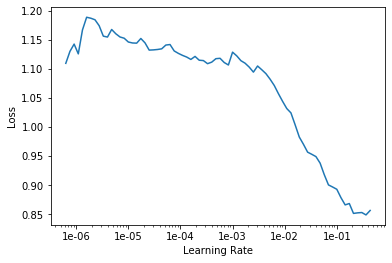

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(10, max_lr = 1e-2)

In [19]:
learn.show_results(10)

In [ ]:
result_counter = {'Normal': 0, 'Low':0, 'High':0}
for i, _ in df.iterrows():
    pred = learn.predict(df.iloc[i])[0].obj
    result_counter[pred] += 1
print (f"High: {result_counter['High']}, Med: {result_counter['Normal']}, Low: {result_counter['Low']}")

In [8]:
df['filename'] = [url.split(r'/')[-2] for url in df['Links']]

In [9]:
df.head()

Downloaded  Engagement (Avg Likes)  \
10         1.0                     NaN   
11         1.0                     NaN   
12         1.0                     NaN   
13         1.0                     NaN   
14         1.0                     NaN   

                                       Links  \
10  https://www.instagram.com/p/B6rIiJMBNuK/   
11  https://www.instagram.com/p/BuR4MIuB_1i/   
12  https://www.instagram.com/p/BgMKji2DXPe/   
13  https://www.instagram.com/p/Bc_EitTjWl5/   
14  https://www.instagram.com/p/BTWasLfDfN4/   

                                             alt-text  \
10                            Image may contain: food   
11                            Image may contain: food   
12           Photo by Ashley Marti on March 11, 2018.   
13  Photo shared by Ashley Marti on December 21, 2...   
14  Photo by Ashley Marti in Elder Hall with @will...   

                                              caption  followers  following  \
10  Yogurt dips always and forever. Labne with Siz...     129270       1341   
11  Made @basically Chicken and Rice Soup with Gar...     129270       1341   
12                 golden beet hummus with sesame oil     129270       1341   
13  Taking a break from all of the holiday cookies...     129270       1341   
14  PORTLAND #giveaway! Enter to win a seat at the...     129270       1341   

     likes  num_posts                  posttime  ... day_name performance  \
10  3003.0       2584  2019-12-29T22:59:01.000Z  ...      7.0        High   
11  4223.0       2584  2019-02-24T21:18:27.000Z  ...      7.0        High   
12  1610.0       2584  2018-03-11T16:43:59.000Z  ...      7.0        High   
13  1191.0       2584  2017-12-22T01:07:08.000Z  ...      5.0         Low   
14  1525.0       2584  2017-04-26T13:29:15.000Z  ...      3.0      Normal   

           red       green        blue  brightness  red_range  green_range  \
10  165.758434  155.697325  147.319075  156.258278      224.0        226.0   
11  195.326505  187.656672  172.342082  185.108420      202.0        185.0   
12  189.139726  170.260187  142.274926  167.224946      152.0        180.0   
13  178.292824  170.629448  159.441829  169.454700      201.0        212.0   
14  176.551989  171.092073  160.501949  169.382004      209.0        212.0   

    blue_range  contrast  
10       236.0     232.0  
11       235.0     214.0  
12       213.0     194.0  
13       224.0     215.0  
14       219.0     214.0  

[5 rows x 32 columns]

# Image Model

In [13]:
#defaults.device = torch.device('cpu')
defaults.device = torch.device('cuda')

In [7]:
data = (ImageList.from_df(df = df, path = 'Output', cols = 'filename', suffix = '.jpg')
        #.filter_by_func(lambda x: print(x))
        .split_by_rand_pct()
        .label_from_df(cols = dep_var)
        .transform([[],[]], size = 400)
        .databunch(bs = 32, num_workers = 0)
       )

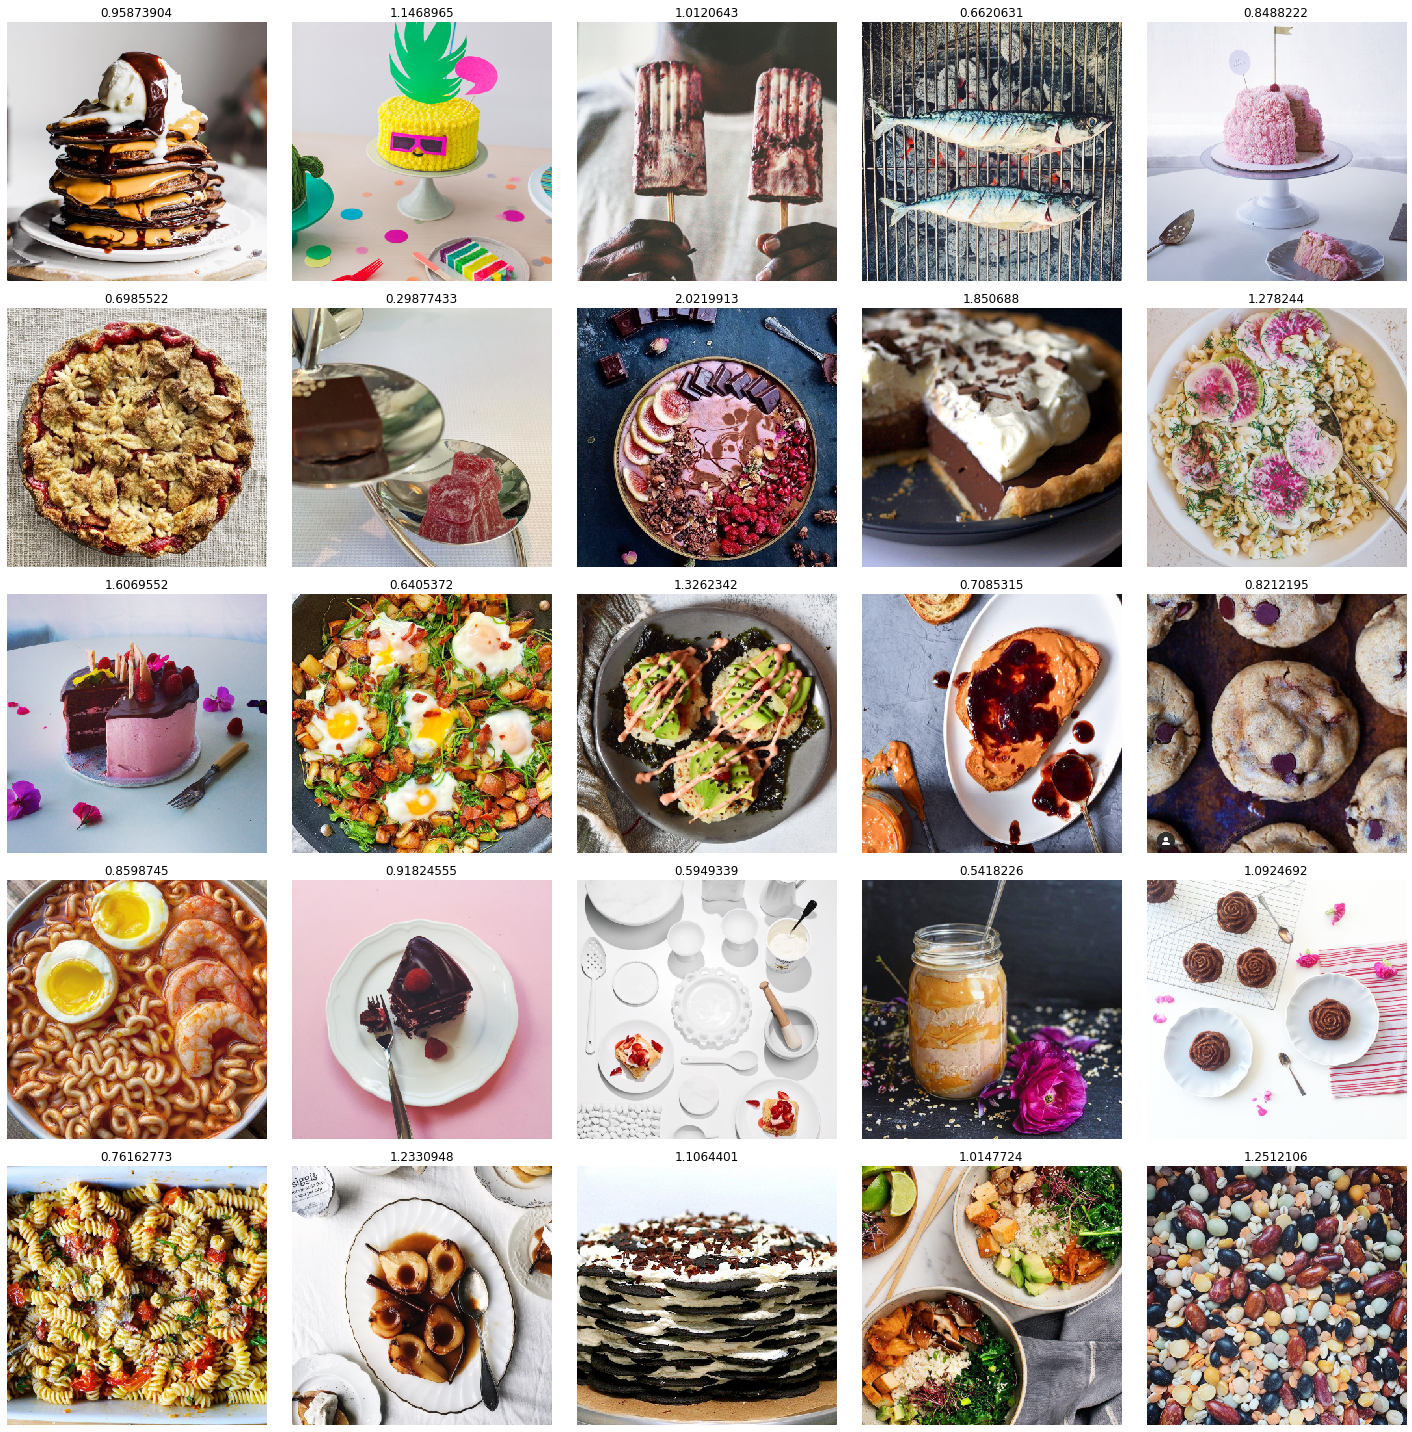

In [8]:
data.show_batch()

In [9]:
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\William/.cache\torch\checkpoints\resnet34-333f7ec4.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:15<00:00, 5.73MB/s]


In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

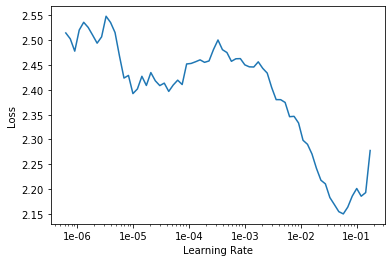

In [22]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(5, max_lr = 1e-2)

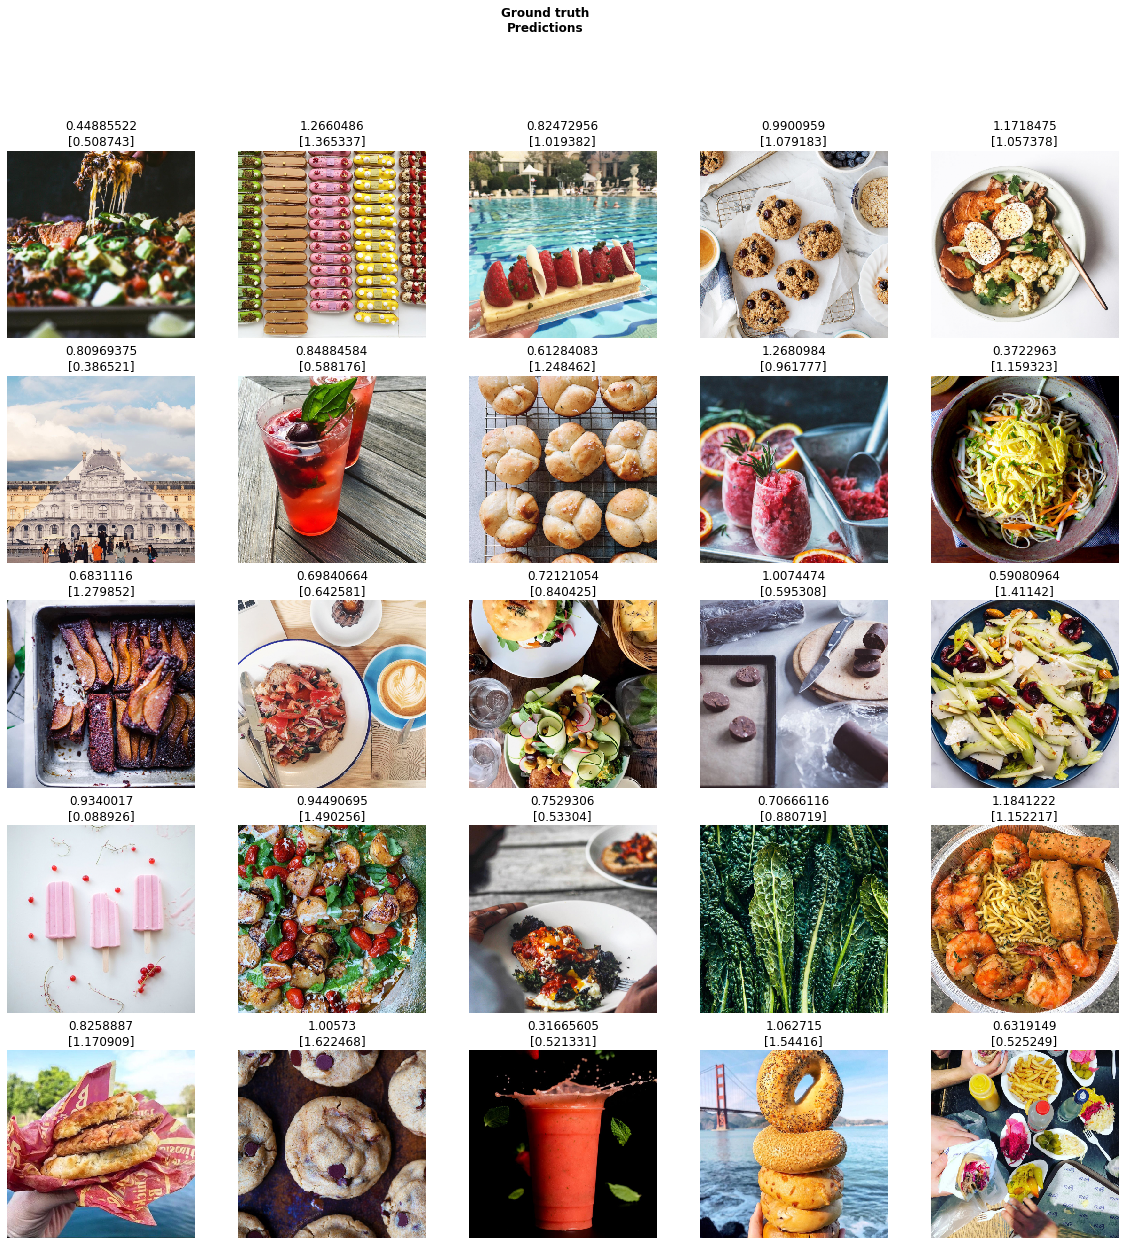

In [11]:
learn.show_results()

In [25]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


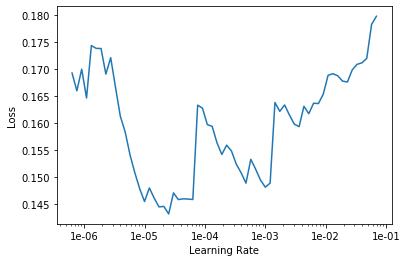

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(20, 1e-2/10)

In [29]:
learn.export('First Attempt.pkl')

In [30]:
interp = learn.interpret()

In [ ]:
learn = load_learner('First Attempt.pkl', num_workers = 0)

In [ ]:
imterp.

# Combined Model

In [11]:
tabularData = TabularList.from_df(df, path = path, cat_names = cat_names, cont_names = cont_names, procs = procs)
imageData = ImageList.from_df(df = df, path = path, cols = 'filename', suffix = '.jpg')